## Imports

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import math
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
from scipy import signal
import scipy.stats as stats
np.random.seed(42)
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)
import os
import pyro.contrib.gp as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(42)

## Data Preparation

In [2]:
### data loading ###
df = pd.read_csv("time_series_data_human_activities.csv") #, index_col=0
print("Number of data points: ", df.shape[0])
print("Number of features: ", df.shape[1])
df.head()

Number of data points:  1073623
Number of features:  6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [3]:
### separate all 36 time series by users ###

#initialize empty array of length 36
user = [None]*36

#for each user, add corresponding data to the user array
for i in range(0,36):
    user[i] = df[(df["user"] == i+1)]
    

In [4]:
### example of data and downsampling ###

user_no = 8 # user 9
x_1 = user[user_no]["x-axis"]
y_1 = user[user_no]["y-axis"]
z_1 = user[user_no]["z-axis"]

q = 8 #downsampling rate
downsampled_x_1 = signal.decimate(x_1, q) #downsample the signal
print("With sampling rate of {}, we went from the original size: {} to: {} sampels.".format(q, x_1.shape[0], downsampled_x_1.shape[0]))

With sampling rate of 8, we went from the original size: 12923 to: 1616 sampels.


Text(0.5, 1.0, 'Example of x-axis signal')

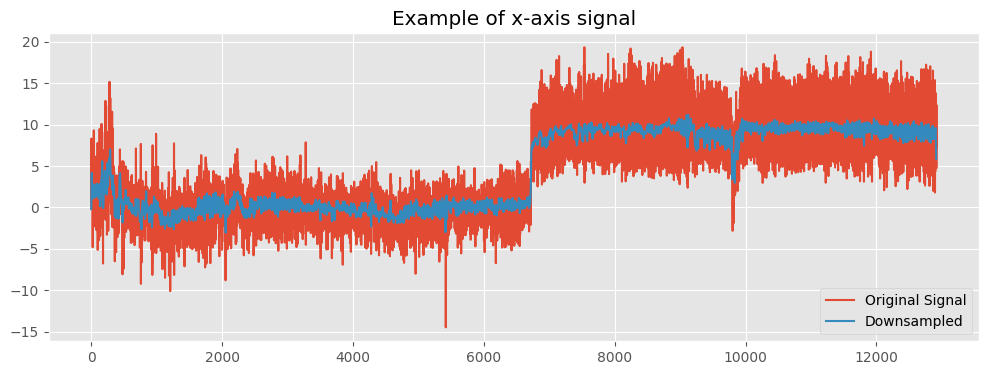

In [5]:
#plot original signal
plt.plot(range(0, x_1.shape[0]), x_1)

#plot downsampled signal
xnew = np.linspace(0, x_1.shape[0], num =downsampled_x_1.shape[0], endpoint=False)
plt.plot(xnew, downsampled_x_1, '-')
plt.legend(['Original Signal', 'Downsampled'], loc='best')
plt.title("Example of x-axis signal")

As can be seen, downsampeld signal is less noisy - more centered around the mean value of the original signal. This approach may lead to reduced noise and increased prediction accuracy because there is less overlap in between the two signal values. This is also acceptable because these data are coming from a wrist watch with a sampling rate of 20 samples per second. Therefore it is easy to average over multiple values without causing any noticable delay for the user.

# Descriptive Statistics

### Distribution

The table below displays the categories of the observations and their corresponding percentages of the data set. (e.g. Walking activity takes up to 38% of the observations)

In [6]:
walking_rate = (df[(df["activity"] == "Walking")].shape[0]/df.shape[0])*100
jogging_rate = (df[(df["activity"] == "Jogging")].shape[0]/df.shape[0])*100
sitting_rate = (df[(df["activity"] == "Sitting")].shape[0]/df.shape[0])*100
standing_Rate = (df[(df["activity"] == "Standing")].shape[0]/df.shape[0])*100
upstairs_rate = (df[(df["activity"] == "Upstairs")].shape[0]/df.shape[0])*100
downstairs_rate = (df[(df["activity"] == "Downstairs")].shape[0]/df.shape[0])*100

d = {'Category': ["Walking", "Jogging", "Sitting", "Standing", "Upstairs", "Downstairs"],
     'Percent': [int(walking_rate), int(jogging_rate), int(sitting_rate), int(standing_Rate), int(upstairs_rate), int(downstairs_rate)]}
df2 = pd.DataFrame(data=d)
df2.style.hide(axis="index")

Category,Percent
Walking,38
Jogging,30
Sitting,5
Standing,4
Upstairs,11
Downstairs,9


## Central Tendency & Dispersion

This sections shows attributes of some of the categories - entire data set is considered before downsampling. The results are summed up in tables at the end of this section.

### Walking

Walking x-axis mean: 1.5477186461418762 and std: 5.828952491732131
Walking y-axis mean: 8.705230987252076 and std: 5.016514309212206
Walking z-axis mean: -0.11261172972644716 and std: 4.020887027555849


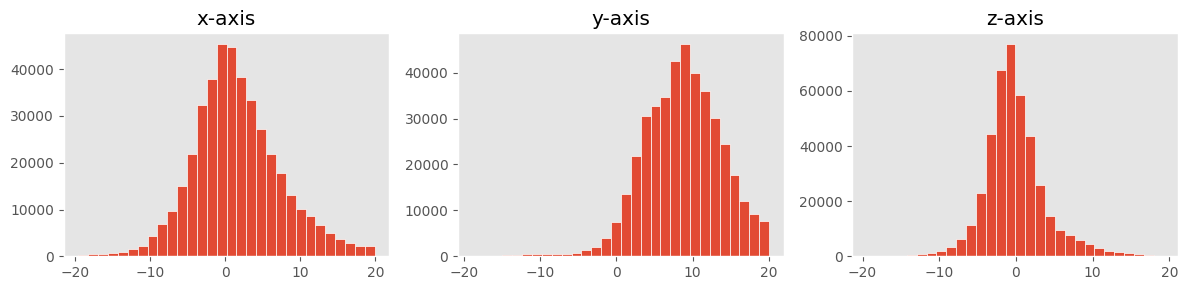

In [7]:
walking = df[(df["activity"] == "Walking")]
print("Walking x-axis mean:", walking["x-axis"].mean(), "and std:", walking["x-axis"].std())
print("Walking y-axis mean:", walking["y-axis"].mean(), "and std:", walking["y-axis"].std())
print("Walking z-axis mean:", walking["z-axis"].mean(), "and std:", walking["z-axis"].std())

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
walking.hist('x-axis', bins=30, edgecolor='w', grid=False, ax=ax1)
walking.hist('y-axis', bins=30, edgecolor='w', grid=False, ax=ax2)
walking.hist('z-axis', bins=30, edgecolor='w', grid=False, ax=ax3)
plt.tight_layout()

### Sitting

Sitting x-axis mean:  1.8562698743722787
Sitting y-axis mean:  1.853373763326048
Sitting z-axis mean:  6.5597164865751845


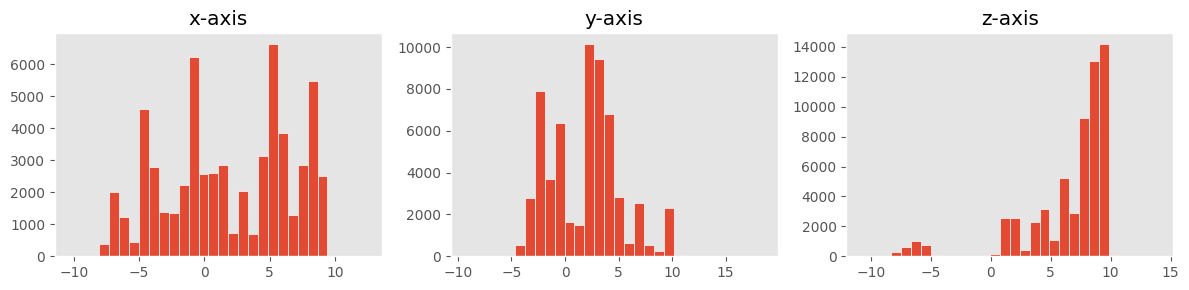

In [8]:
sitting = df[(df["activity"] == "Sitting")]
print("Sitting x-axis mean: ", sitting["x-axis"].mean())
print("Sitting y-axis mean: ", sitting["y-axis"].mean())
print("Sitting z-axis mean: ", sitting["z-axis"].mean())

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
sitting.hist('x-axis', bins=30, edgecolor='w', grid=False, ax=ax1)
sitting.hist('y-axis', bins=30, edgecolor='w', grid=False, ax=ax2)
sitting.hist('z-axis', bins=30, edgecolor='w', grid=False, ax=ax3)
plt.tight_layout()

### Jogging

Jogging x-axis mean:  -0.22710424498253237
Jogging y-axis mean:  5.6324030299630135
Jogging z-axis mean:  -0.15577021955447934


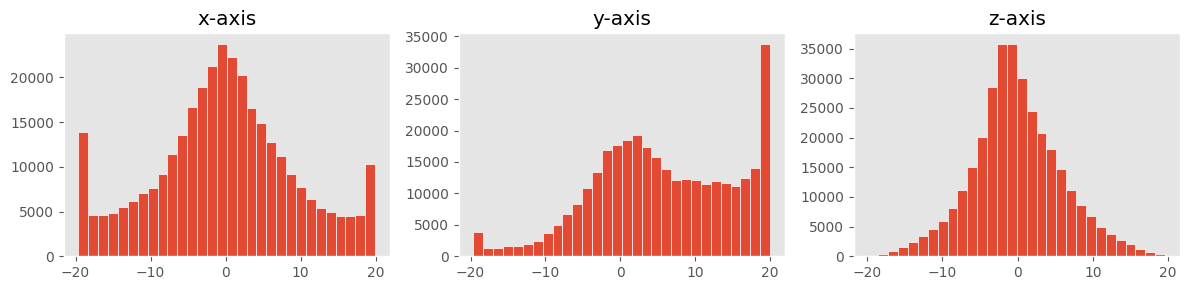

In [9]:
jogging = df[(df["activity"] == "Jogging")]
print("Jogging x-axis mean: ", jogging["x-axis"].mean())
print("Jogging y-axis mean: ", jogging["y-axis"].mean())
print("Jogging z-axis mean: ", jogging["z-axis"].mean())

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
jogging.hist('x-axis', bins=30, edgecolor='w', grid=False, ax=ax1)
jogging.hist('y-axis', bins=30, edgecolor='w', grid=False, ax=ax2)
jogging.hist('z-axis', bins=30, edgecolor='w', grid=False, ax=ax3)
plt.tight_layout()

### Standing

Standing x-axis mean:  -1.1782691711611184
Standing y-axis mean:  8.98741574194615
Standing z-axis mean:  0.5801385403078544


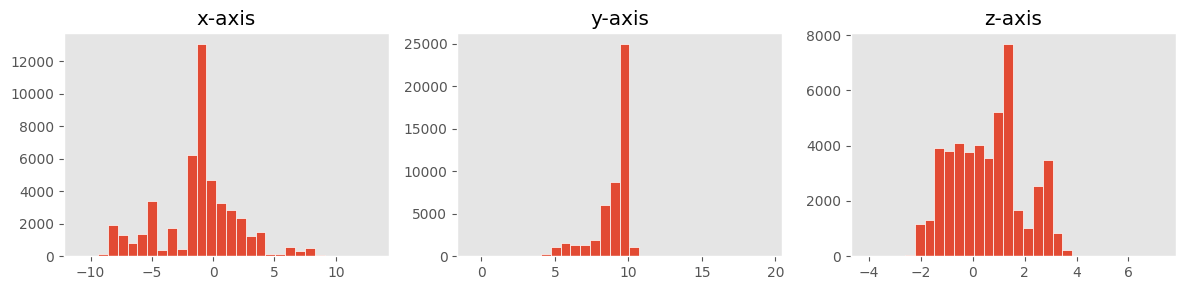

In [10]:
standing = df[(df["activity"] == "Standing")]
print("Standing x-axis mean: ", standing["x-axis"].mean())
print("Standing y-axis mean: ", standing["y-axis"].mean())
print("Standing z-axis mean: ", standing["z-axis"].mean())

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
standing.hist('x-axis', bins=30, edgecolor='w', grid=False, ax=ax1)
standing.hist('y-axis', bins=30, edgecolor='w', grid=False, ax=ax2)
standing.hist('z-axis', bins=30, edgecolor='w', grid=False, ax=ax3)
plt.tight_layout()

In [11]:
upstairs = df[(df["activity"] == "Upstairs")]
downstairs = df[(df["activity"] == "Downstairs")]

stats_Data = {
'Category': ["Walking", "Jogging", "Sitting", "Standing", "Upstairs", "Downstairs"],
'Mean (x)': [walking["x-axis"].mean(), jogging["x-axis"].mean(), sitting["x-axis"].mean(), standing["x-axis"].mean(), upstairs["x-axis"].mean(), downstairs["x-axis"].mean()],
'Median (x)': [walking["x-axis"].median(), jogging["x-axis"].median(), sitting["x-axis"].median(), standing["x-axis"].median(), upstairs["x-axis"].median(), downstairs["x-axis"].median()],
'Mode (x)': [walking["x-axis"].mode()[0], jogging["x-axis"].mode()[0], sitting["x-axis"].mode()[0], standing["x-axis"].mode()[0], upstairs["x-axis"].mode()[0], downstairs["x-axis"].mode()[0]],
'Standard deviation (x)': [walking["x-axis"].std(), jogging["x-axis"].std(), sitting["x-axis"].std(), standing["x-axis"].std(), upstairs["x-axis"].std(), downstairs["x-axis"].std()],
'Variance (x)': [walking["x-axis"].var(), jogging["x-axis"].var(), sitting["x-axis"].var(), standing["x-axis"].var(), upstairs["x-axis"].var(), downstairs["x-axis"].var()],
}

stats_df = pd.DataFrame(data=stats_Data)
stats_df.style.hide(axis="index")

Category,Mean (x),Median (x),Mode (x),Standard deviation (x),Variance (x)
Walking,1.547719,0.990000,-0.460000,5.828952,33.976687
Jogging,-0.227104,-0.230000,-19.610000,9.333826,87.120314
Sitting,1.856270,1.530000,8.200000,4.759028,22.648347
Standing,-1.178269,-1.120000,-1.140000,3.235186,10.466431
Upstairs,0.382177,0.150000,-0.040000,5.501313,30.264444
Downstairs,0.472726,0.080000,-0.230000,4.961663,24.618105


In [12]:
stats_Data_y = {
'Category': ["Walking", "Jogging", "Sitting", "Standing", "Upstairs", "Downstairs"],
'Mean (y)': [walking["y-axis"].mean(), jogging["y-axis"].mean(), sitting["y-axis"].mean(), standing["y-axis"].mean(), upstairs["y-axis"].mean(), downstairs["y-axis"].mean()],
'Median (y)': [walking["y-axis"].median(), jogging["y-axis"].median(), sitting["y-axis"].median(), standing["y-axis"].median(), upstairs["y-axis"].median(), downstairs["y-axis"].median()],
'Mode (y)': [walking["y-axis"].mode()[0], jogging["y-axis"].mode()[0], sitting["y-axis"].mode()[0], standing["y-axis"].mode()[0], upstairs["y-axis"].mode()[0], downstairs["y-axis"].mode()[0]],
'Standard deviation (y)': [walking["y-axis"].std(), jogging["y-axis"].std(), sitting["y-axis"].std(), standing["y-axis"].std(), upstairs["y-axis"].std(), downstairs["y-axis"].std()],
'Variance (y)': [walking["y-axis"].var(), jogging["y-axis"].var(), sitting["y-axis"].var(), standing["y-axis"].var(), upstairs["y-axis"].var(), downstairs["y-axis"].var()],
}

stats_df_y = pd.DataFrame(data=stats_Data_y)
stats_df_y.style.hide(axis="index")

Category,Mean (y),Median (y),Mode (y),Standard deviation (y),Variance (y)
Walking,8.705231,8.770000,8.850000,5.016514,25.165416
Jogging,5.632403,5.010000,19.570000,9.323852,86.934212
Sitting,1.853374,2.490000,2.530000,3.257750,10.612937
Standing,8.987416,9.430000,9.920000,1.264137,1.598042
Upstairs,8.129476,8.580000,9.110000,4.881203,23.826143
Downstairs,8.620225,8.580000,8.730000,4.892873,23.940205


In [13]:
stats_Data_z = {
'Category': ["Walking", "Jogging", "Sitting", "Standing", "Upstairs", "Downstairs"],
'Mean (z)': [walking["z-axis"].mean(), jogging["z-axis"].mean(), sitting["z-axis"].mean(), standing["z-axis"].mean(), upstairs["z-axis"].mean(), downstairs["z-axis"].mean()],
'Median (z)': [walking["z-axis"].median(), jogging["z-axis"].median(), sitting["z-axis"].median(), standing["z-axis"].median(), upstairs["z-axis"].median(), downstairs["z-axis"].median()],
'Mode (z)': [walking["z-axis"].mode()[0], jogging["z-axis"].mode()[0], sitting["z-axis"].mode()[0], standing["z-axis"].mode()[0], upstairs["z-axis"].mode()[0], downstairs["z-axis"].mode()[0]],
'Standard deviation (z)': [walking["z-axis"].std(), jogging["z-axis"].std(), sitting["z-axis"].std(), standing["z-axis"].std(), upstairs["z-axis"].std(), downstairs["z-axis"].std()],
'Variance (z)': [walking["z-axis"].var(), jogging["z-axis"].var(), sitting["z-axis"].var(), standing["z-axis"].var(), upstairs["z-axis"].var(), downstairs["z-axis"].var()],
}

stats_df_z = pd.DataFrame(data=stats_Data_z)
stats_df_z.style.hide(axis="index")

Category,Mean (z),Median (z),Mode (z),Standard deviation (z),Variance (z)
Walking,-0.112612,-0.570000,0.000000,4.020887,16.167532
Jogging,-0.155770,-0.530000,0.000000,5.952950,35.437610
Sitting,6.559716,8.117727,8.240000,3.735591,13.954643
Standing,0.580139,0.650000,1.380000,1.376819,1.895629
Upstairs,0.324257,0.081722,0.000000,3.571793,12.757706
Downstairs,0.685678,0.503953,0.000000,3.710944,13.771104


# Exploration of data

It is worth noticing that the mean (approxiated by the blue line in the plot below) of the measurements can vary for different people, meaning that the means of measurenmnets are also normally distributed.

C:\Users\Patrik\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


Text(0.5, 1.0, 'Example of x-axis signal')

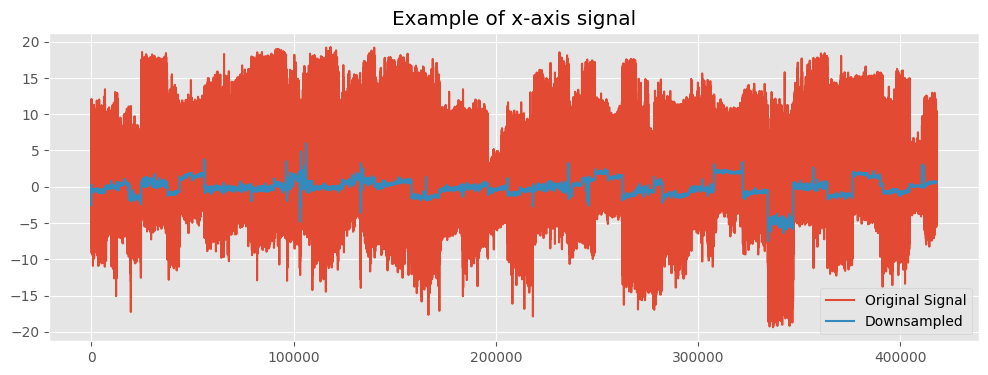

In [14]:
sampling_rate = 64
o_walking_z = walking["z-axis"] #original walking z-axis
d_walking_z = signal.decimate(o_walking_z, sampling_rate) #sampled walking z-axis

plt.plot(range(0, walking["z-axis"].shape[0]), walking["z-axis"])
xnew = np.linspace(0, walking["z-axis"].shape[0], num =d_walking_z.shape[0], endpoint=False)
plt.plot(xnew, d_walking_z, '-')
plt.legend(['Original Signal', 'Downsampled'], loc='best')
plt.title("Example of x-axis signal")

Another considered features were frequencies of the signals. However, this does not seem to be much informative in the case given as can be seen from the STFT (Short Time Fourier Transform) below. This is also observable in the next plot.

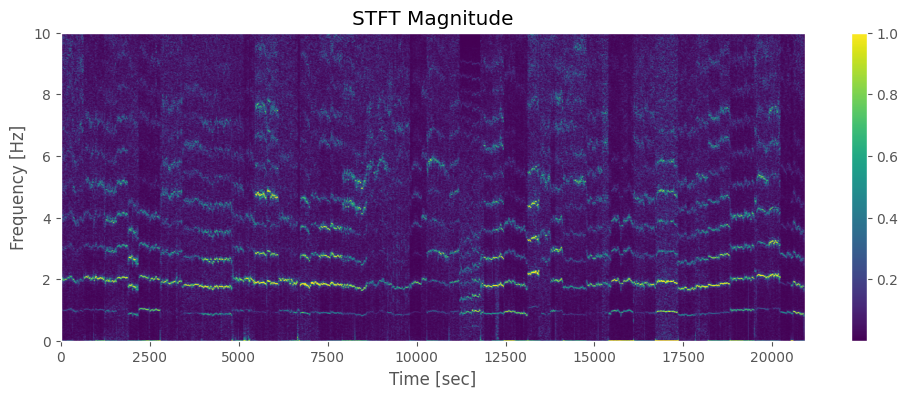

In [15]:
w_x = walking["z-axis"]
f, t, Zxx = signal.stft(w_x, 20, nperseg=1024, window="hamming")
window_ham = signal.windows.hamming(51)
plt.pcolormesh(t, f, np.abs(Zxx), vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

The plot below shows the distributions of frequencies. Even though there is something resembling normal distributions, the peaks are very low - highest 0.07 and the rest is 0.03 so there is no big difference.

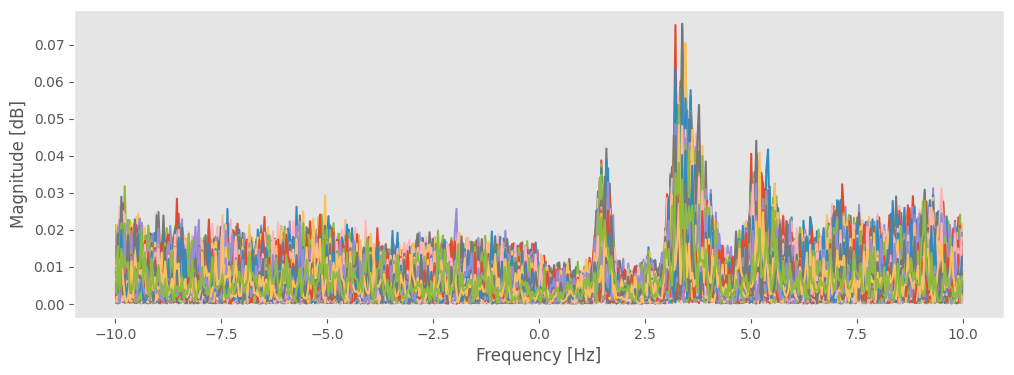

In [16]:
from scipy.fft import fft, fftfreq, fftshift
# number of signal points
data = Zxx[10:]
N = data.shape[0]
# sample spacing
T = 1/20
x = np.linspace(0.0, N*T, N, endpoint=False)
y = data
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)
import matplotlib.pyplot as plt
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.grid()
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.show()

# Testing for GP Classification

In this section we verify that the GP classification can be used with the data set given. First the classification is tested with only 2 features, namely: x-axis and y-axis acceleration with only 2 categories: sitting and jogging.

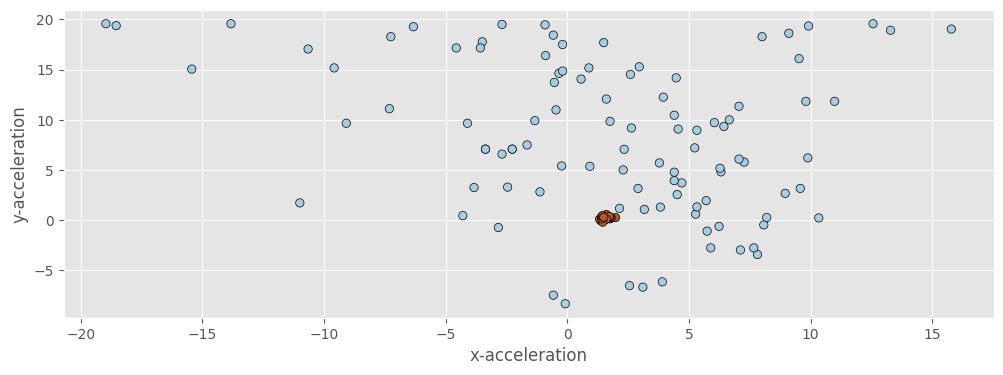

In [17]:
#separate desired category data
gp_data_sitting = df[(df["activity"].isin(["Sitting"]))]
gp_data_jogging = df[(df["activity"].isin(["Jogging"]))]

#take only first 100 samples
sitting_h = gp_data_sitting.iloc[:100]
jogging_h = gp_data_jogging.iloc[:100]

frames = [sitting_h, jogging_h]
gp_data = pd.concat(frames)

X = torch.from_numpy(gp_data[gp_data.columns[3:5]].values.astype("float32"),) #get x-axis and y-axis
gp_data["activity"] = gp_data["activity"].astype("category")
y = torch.from_numpy(gp_data["activity"].cat.codes.values.copy())

#plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.xlabel("x-acceleration")
_ = plt.ylabel("y-acceleration")

As can be seen from the plot above, even though the x and y measurements are overlaping in the feature space, the measurements for the sitting are concentrated around a certain point with very samll variance. Meanwhile it can be observed that the data of jogging activity have much higher variance.

In [18]:
kernel = gp.kernels.RBF(input_dim=2)
pyro.clear_param_store()
likelihood = gp.likelihoods.MultiClass(num_classes=2)

model = gp.models.VariationalGP(
    X,
    y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([2]),
)
num_steps = 800
loss = gp.util.train(model, num_steps=num_steps)

mean, var = model(X)
y_hat = model.likelihood(mean, var)
print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 97.00%


Next we can visualize the prediction uncertainty in the feature space. As can be seen from the plot below, the model is able to separate the 2 classes wih high accuracy which makes it a possibly a suitable model for the given classification problem.

In [19]:
xs = torch.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, steps=400)
ys = torch.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, steps=400)
xx, yy = torch.meshgrid(xs, ys, indexing="xy")

with torch.no_grad():
    mean, var = model(torch.vstack((xx.ravel(), yy.ravel())).t())
    Z = model.likelihood(mean, var)
    
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            torch.sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)
        ax.grid(False)

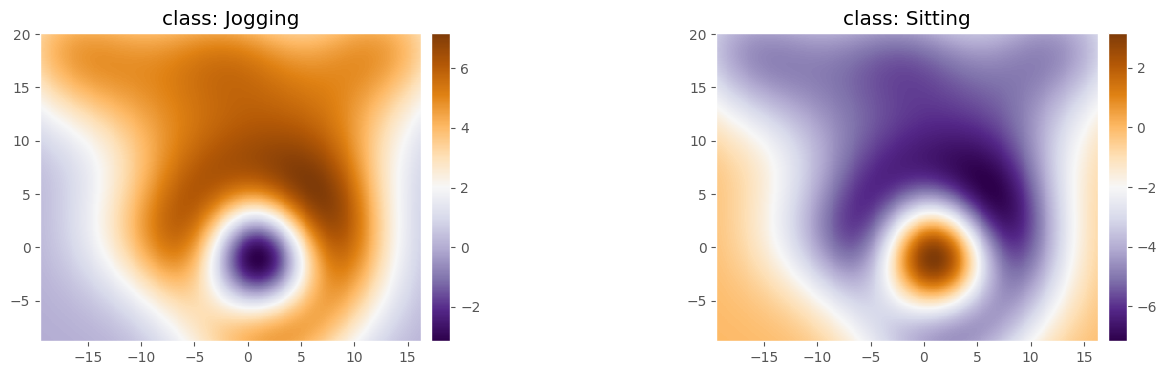

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
names = ["Jogging", "Sitting"]
for cl in [0, 1]:
    n = names[cl]
    plot_pred_2d(
        mean[cl, :].reshape(xx.shape), xx, yy, ax=ax[cl], title=f"class: {n}"
    )

# GP Classification

In this section the previous solution is extended to handle 4 classes - sitting, jogging, standing and walking. All 3 features (x, y and z accelerations) are used for the classification task using the Gaussian processes as priors and categorical distribution as likelihood.

## Step 1: Downsampling entire dataset

In [ ]:
d_r = 20 #downsampling rate
df_down = pd.DataFrame(columns=['user', 'activity', 'x-axis', 'y-axis', 'z-axis']) #initialize downsampled df

for j in range(0,36):
    unique_activities = user[j].activity.unique().tolist()
    for activity in unique_activities:
        condition = (df['activity'] == activity)
        x = signal.decimate(user[j][condition]['x-axis'], d_r)
        y = signal.decimate(user[j][condition]['y-axis'], d_r)
        z = signal.decimate(user[j][condition]['z-axis'], d_r)
        activity = user[j][condition]['activity'][:x.shape[0]]
        user_col = user[j][condition]['user'][:x.shape[0]]
        merged_columns = np.vstack((user_col, activity, x,y,z)).T
        df_down2 = pd.DataFrame(merged_columns, columns=['user', 'activity', 'x-axis', 'y-axis', 'z-axis'])
        df_down = pd.concat([df_down, df_down2])

In [22]:
#choose classes we want to use
gp_data_sitting = df_down[(df_down["activity"].isin(["Sitting"]))]
gp_data_jogging = df_down[(df_down["activity"].isin(["Jogging"]))]
gp_data_walking = df_down[(df_down["activity"].isin(["Walking"]))]
gp_data_standing = df_down[(df_down["activity"].isin(["Standing"]))]
#gp_data_upstairs = df_down[(df_down["activity"].isin(["Upstairs"]))]
#gp_data_downstairs = df_down[(df_down["activity"].isin(["Downstairs"]))]

#use n random samples from the dataset for each category to make the dataset balanced
no_samples = 350

sitting_h = gp_data_sitting.sample(no_samples)
jogging_h = gp_data_jogging.sample(no_samples)
walking_h = gp_data_walking.sample(no_samples)
standing_h = gp_data_standing.sample(no_samples)
#upstairs_h = gp_data_upstairs.sample(no_samples)
#downstairs_h = gp_data_downstairs.sample(no_samples)

frames = [sitting_h, jogging_h, standing_h, walking_h] #, upstairs_h, downstairs_h]
gp_data = pd.concat(frames)
X = torch.from_numpy(gp_data[gp_data.columns[2:5]].values.astype("float32"),)

# Step 2: Data Exploration
This section explores the correlation between the data to see what would be a suitable kernel option for GP.


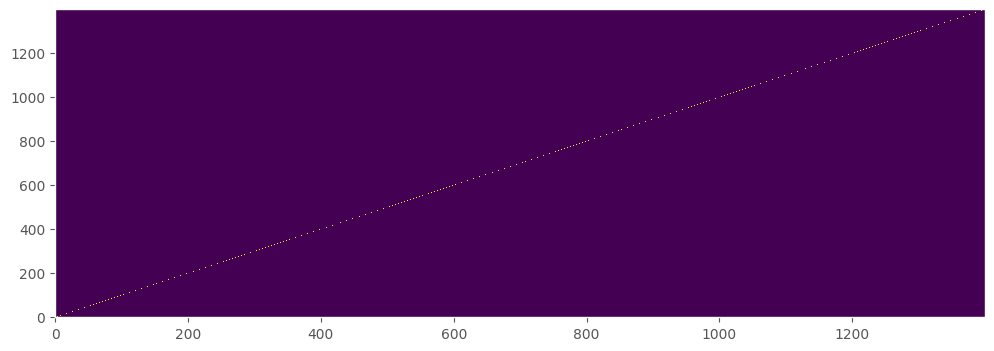

In [23]:
### correlation of the signal ###
jogging_df = gp_data[(gp_data['activity'] == 'Jogging')]
jogging_df = gp_data['x-axis']
jogging_df = pd.to_numeric(jogging_df)

squared_exponential = lambda tau_squared, kappa, scale: kappa**2*np.exp(-0.5*tau_squared/scale**2)

def apply(X1, X2, kappa, scale, jitter=1e-8):
    dists_squared = np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1)
    K = squared_exponential(dists_squared, kappa, scale)
    
    if len(X1) == len(X2) and np.allclose(X1, X2):
        K = K + jitter*np.identity(len(X1))
    return K

#the value of kappa is 9.33 => variance of the jogging signal was used, lengthscale of 20 was used to show that even with
#large lengthscale the signal has low covariance
Kpp = apply(jogging_df, jogging_df, 9.33, 20)
plt.pcolormesh(range(0, jogging_df.shape[0]), range(0, jogging_df.shape[0]), Kpp, shading='auto')

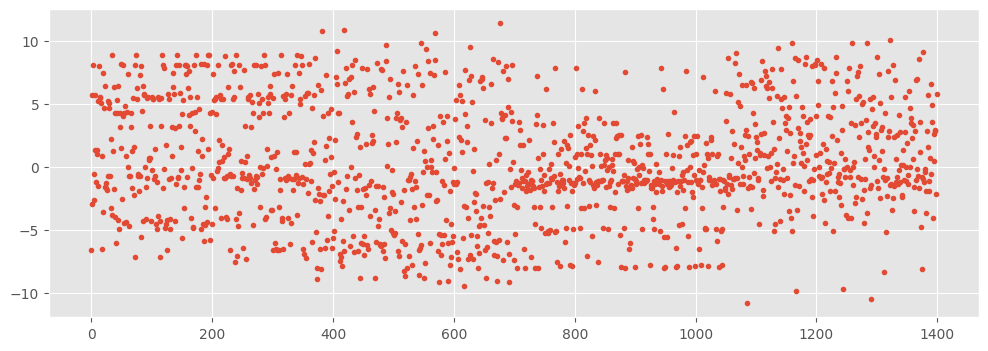

In [24]:
#plotting the measurements for jogging x-axis
plt.plot(range(0, jogging_df.shape[0]), jogging_df, ".")

Since there is a low covariance, the gaussian kernel and Matern32 will be used.

## Step 3: GP Classification

In [29]:
#set category
categories =  gp_data["activity"].astype("category")
d = dict(enumerate(categories.cat.categories)) #getting dictonary between categories encoded as numbers
encodings = list(d.values()) #corresponding categories for plots
gp_data["activity"] = gp_data["activity"].astype("category")

# encoding as numerical categories
y = torch.from_numpy(gp_data["activity"].cat.codes.values.copy())

Text(0.5, 1.0, 'Training Loss')

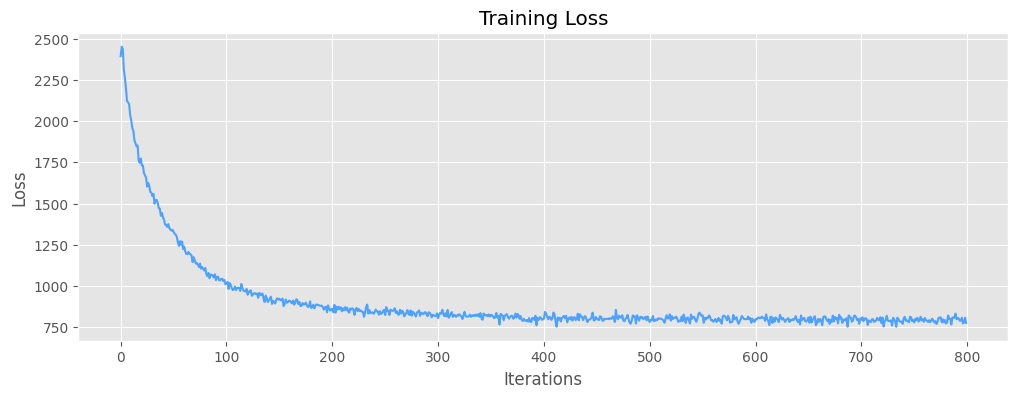

In [25]:
#model creation:

#kernel type
kernel = gp.kernels.Matern32(input_dim=3) # Matern32 and RBF are best
pyro.clear_param_store()
#select likelihood
likelihood = gp.likelihoods.MultiClass(num_classes=len(frames))
#model selection
model = gp.models.VariationalGP(
    X,
    y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([len(frames)]),
)

#training
num_steps = 800
loss = gp.util.train(model, num_steps=num_steps)

plt.plot(loss, color = "#4da2ff")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")

Accuracy: 82.57%


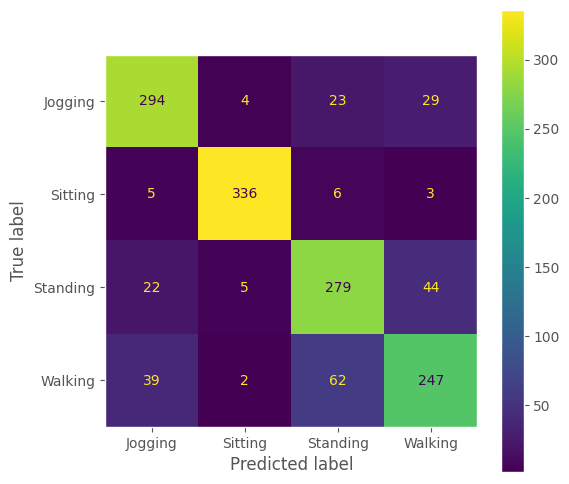

In [27]:
#this section plots confusion matrix and prints training accuracy
fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
mean, var = model(X)
y_hat = model.likelihood(mean, var)
print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")
ls = np.array(encodings)#,"Upstairs","Downstairs"])
cm = confusion_matrix(y, y_hat, labels=[0, 1, 2, 3]) #, 4, 5])
ConfusionMatrixDisplay(cm, display_labels=ls).plot(ax=ax)

In [31]:
### second model using RBF kernel ###

#kernel type: RBF
kernel2 = gp.kernels.RBF(input_dim=3) # Matern32 and RBF are best
pyro.clear_param_store()

#model selection
model_rbf = gp.models.VariationalGP(
    X,
    y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([len(frames)]),
)

#training
num_steps = 800
loss2 = gp.util.train(model_rbf, num_steps=num_steps)

In [32]:
#initialize arrays to collect accuracies
accuracies = []
accuracies_rbf = []
no_val_samples = 1000 #number of validation samples

for i in range(30):
    #randomly sample N samples
    sitting_val = gp_data_sitting.sample(no_val_samples)
    jogging_val = gp_data_jogging.sample(no_val_samples)
    standing_val = gp_data_standing.sample(no_val_samples)

    #arrange samples into x_validation and y_validation sets
    frames_val = [sitting_val, jogging_val, standing_val] #, upstairs_h, downstairs_h]
    gp_data_val = pd.concat(frames_val)
    gp_data_val["activity"] = gp_data_val["activity"].astype("category")

    X_val = torch.from_numpy(gp_data[gp_data.columns[2:5]].values.astype("float32"),)
    y_val = torch.from_numpy(gp_data_val["activity"].cat.codes.values.copy())

    #predict  - first model
    mean, var = model(X_val)
    y_hat = model.likelihood(mean, var)
    #compare to true labels
    accuracy = (y_hat==y).sum()*100/(len(y))
    accuracies.append(accuracy.tolist())
    
    #predict - second model with RBF kernel
    mean2, var2 = model_rbf(X_val)
    y_hat2 = model_rbf.likelihood(mean, var)
    #compare to true labels
    accuracy2 = (y_hat2==y).sum()*100/(len(y))
    accuracies_rbf.append(accuracy2.tolist())

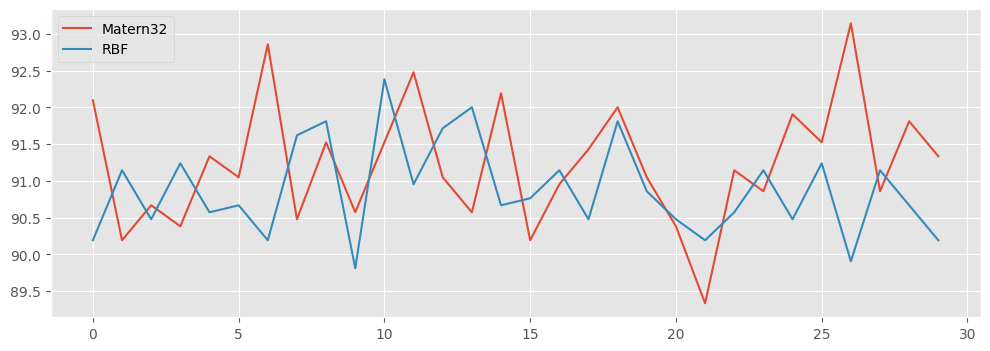

In [33]:
plt.plot(accuracies)
plt.plot(accuracies_rbf) #rbf
plt.legend(['Matern32', 'RBF'])

In [34]:
print('Mean accuracy for the model with Matern32 kernel: ', np.array(accuracies).mean())
print('Mean accuracy for the model with RBF kernel: ', np.array(accuracies_rbf).mean())

Mean accuracy for the model with Matern32 kernel:  91.22857157389323
Mean accuracy for the model with RBF kernel:  90.88253936767578


# Conslusion

Two kernels were explored and both perform equally well but Matern32 kernel was selected. The GP classification model managed to distinguish between the 4 classes given, with an accuracy of 83 %. This means that the model performs much better then a random guess (which would be 25%). The model could be further improved by collecting more information e.g. GPS signal to better distinguish between the walking class and jogging class as the persons velocity would provide information not captured by the acceleration information from ones wrist.